In [7]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.fft import fft
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Reading data from .bdf files

In [2]:
folder_path = 'data'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.bdf')]

X_all = []
y_all = []
durations = []
for file_name in file_names[:20]:
    file_path = os.path.join(folder_path, file_name)
    raw = mne.io.read_raw_bdf(file_path, preload=True)

    events = mne.find_events(raw, shortest_event=1)

    event_id = {'awe': 9,
                'frustration': 10,
                'joy': 11,
                'anger': 12,
                'happy': 13,
                'sad': 14,
                'love': 15,
                'fear': 16,
                'compassion': 17,
                'jealousy': 18,
                'content': 19,
                'grief': 20,
                'relief': 21,
                'excite': 22,
                'disgust': 23,
                'none': 0  # added this line to include non-events
                }

    avg_duration = np.mean(np.diff(events[:, 0]))

    none_events = []
    none_count = 0  # counter for 'none' events
    for i in range(1, len(events)):
        gap = events[i][0] - events[i-1][0]
        if gap > avg_duration * 2:  # only add "none" event if gap is longer than twice the average duration
            none_start = events[i-1][0] + gap // 2  # start "none" event in the middle of the gap
            none_events.append([none_start, 0, event_id['none']])
            none_count += 1
            if none_count >= 1:  # limit to 2 'none' events per file
                break

    events = np.vstack((events, none_events))
    events = events[events[:, 0].argsort()]  # sort events by time

    existing_event_ids = set(events[:, 2])
    filtered_event_id = {k: v for k, v in event_id.items() if v in existing_event_ids}

    epochs = mne.Epochs(raw, events, filtered_event_id, tmin=-3, tmax=2, baseline=None)

    X = epochs.get_data()
    y = epochs.events[:, -1]
    print('File', file_name, 'shape: ', X.shape, y.shape)
    X_all.append(X)
    y_all.append(y)

    for i in range(1, len(events)):
        start_time_current_event = events[i - 1, 0]
        start_time_next_event = events[i, 0]
        duration = (start_time_next_event - start_time_current_event) / raw.info['sfreq']
        event_id = events[i - 1, 2]
        if event_id >= 9 and event_id <= 23:
            durations.append((event_id, duration))

X = np.concatenate(X_all)
y = np.concatenate(y_all)

Extracting EDF parameters from C:\Artificial Intelligence\S8\MachinePerception\project\data\eeg_recording_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1155327  =      0.000 ...  4512.996 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
86 events found
Event IDs: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  30 100]
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 1281 original time points ...
0 bad epochs dropped
File eeg_recording_1.bdf shape:  (16, 265, 1281) (16,)
Extracting EDF parameters from C:\Artificial Intelligence\S8\MachinePerception\project\data\eeg_recording_10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.inf

In [3]:
print("Shape of decision variables:", X.shape)
print("shape of target variables:", y.shape)

Shape of decision variables: (320, 265, 1281)
shape of target variables: (320,)


## Functions used for data modification

In [4]:
def data_extension(X, y, n_segments):
    extented_X = []
    extended_y = []

    segment_duration = int(X.shape[2] / n_segments)

    for i in range(X.shape[0]):
        for j in range(n_segments):
            start = j * segment_duration
            segment = X[i, :, start : start + segment_duration]
            extented_X.append(segment)
            extended_y.append(y[i])

    return np.array(extented_X), np.array(extended_y)


def data_augmentation(X, y, n_segments, segment_duration=None, is_noise = True, noise_std=None, noise_per_channel=False, random_seed=42):
    np.random.seed(random_seed)
    augmented_X = []
    augmented_y = []

    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])

    if noise_std is None:
        if noise_per_channel:
            noise_std = np.std(X, axis=(0, 2)) / 10
        else:
            noise_std = np.std(X) / 10

    if not is_noise:
        noise_std = 0

    for i in range(X.shape[0]):
        for _ in range(n_segments):
            start = np.random.randint(0, X.shape[2] - segment_duration)
            segment = X[i, :, start : start + segment_duration]
            noise = np.random.normal(0, noise_std, segment.shape[::-1]).transpose()
            augmented_segment = segment + noise
            augmented_X.append(augmented_segment)
            augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)


def extract_segments(X, segment_duration):
    if segment_duration is None:
        segment_duration = int(0.5 * X.shape[2])
    n_segments = X.shape[2] // segment_duration
    extracted_X = []

    for i in range(X.shape[0]):
        for j in range(n_segments):
            start = j * segment_duration
            segment = X[i, :, start : start + segment_duration]
            extracted_X.append(segment)

    return np.array(extracted_X)

In [5]:
def test_all_classifiers(X_train, X_test, y_train, y_test, augmentation = False):
#     X, y = data_augmentation(X, y, 12, is_noise=is_noise, noise_per_channel=noise_per_channel)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    if augmentation:
        X_train, y_train = data_augmentation(X_train, y_train, 5, is_noise=True, noise_per_channel=True)

        X_test = extract_segments(X_test, segment_duration=int(0.5 * X.shape[2]))
        y_test = np.repeat(y_test, X_test.shape[0] // y_test.shape[0])

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Logistic Regression
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
#     print(y_test, y_pred)
    log_accuracy = accuracy_score(y_test, y_pred)
    print(f'Logistic Regression accuracy: {log_accuracy:.2f}')

    # Support Vector Classification
    pipeline = make_pipeline(
        StandardScaler(),
        SVC()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    svc_accuracy = accuracy_score(y_test, y_pred)
    print(f'SVC accuracy: {svc_accuracy:.2f}')

    # Random Forest Classification
    pipeline = make_pipeline(
        StandardScaler(),
        RandomForestClassifier()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rand_accuracy = accuracy_score(y_test, y_pred)
    print(f'Random Forest accuracy: {rand_accuracy:.2f}')

    # K-Nearest Neighbors Classification
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred)
    print(f'K-Nearest Neighbors accuracy: {knn_accuracy:.2f}')

    return log_accuracy, svc_accuracy, rand_accuracy, knn_accuracy

## Results for only basic data preprocessing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, y_train = data_extension(X_train, y_train, 5)
X_test, y_test = data_extension(X_test, y_test, 5)

In [8]:
test_all_classifiers(X_train, X_test, y_train, y_test)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.01
SVC accuracy: 0.00
Random Forest accuracy: 0.01
K-Nearest Neighbors accuracy: 0.00


(0.0075, 0.0, 0.01, 0.0)

## Results for FFT

**FFT visualised**

Magnitude:


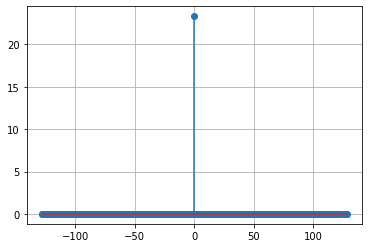

Real part:


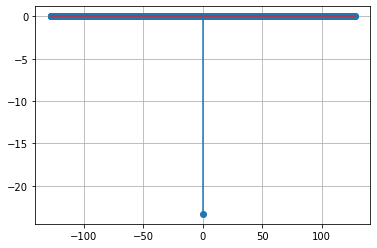

Imaginary part:


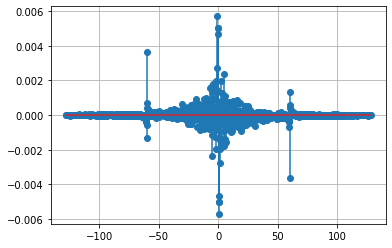

In [9]:
plot_x = np.fft.fftfreq(1281, 1/raw.info['sfreq'])
plot_y = np.fft.fft(X)

print("Magnitude:")
plt.stem(plot_x, np.abs(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

print("Real part:")
plt.stem(plot_x, np.real(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

print("Imaginary part:")
plt.stem(plot_x, np.imag(plot_y[0,0]), use_line_collection=True)
plt.grid()
plt.show()

**FFT visualised (without the dominating frequency)**

Magnitude:


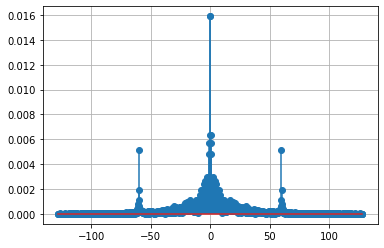

Real part:


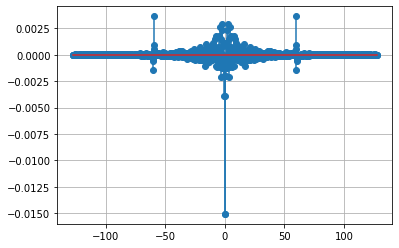

Imaginary part:


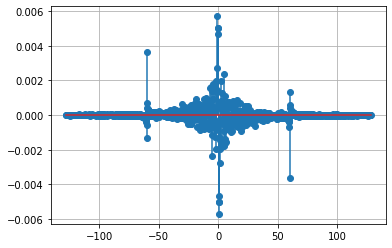

In [10]:
print("Magnitude:")
plt.stem(plot_x[1:], np.abs(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

print("Real part:")
plt.stem(plot_x[1:], np.real(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

print("Imaginary part:")
plt.stem(plot_x[1:], np.imag(plot_y[0,0,1:]), use_line_collection=True)
plt.grid()
plt.show()

**FFT applied to full data**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, y_train = data_extension(X_train, y_train, 5)
X_test, y_test = data_extension(X_test, y_test, 5)

X_train = np.fft.fft(X_train)
X_train = np.concatenate([np.real(X_train), np.imag(X_train)], axis=1)

X_test = np.fft.fft(X_test)
X_test = np.concatenate([np.real(X_test), np.imag(X_test)], axis=1)

In [21]:
test_all_classifiers(X_train, X_test, y_train, y_test)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.07
SVC accuracy: 0.04
Random Forest accuracy: 0.06
K-Nearest Neighbors accuracy: 0.05


(0.075, 0.045, 0.0575, 0.0475)

## Results for PSD tranformation

In [22]:
import scipy.signal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, y_train = data_extension(X_train, y_train, 5)
X_test, y_test = data_extension(X_test, y_test, 5)

freqs, psd = scipy.signal.welch(X_train, fs=raw.info['sfreq'], nperseg=180, noverlap=90, axis=1)
X_train = np.concatenate([np.real(psd), np.imag(psd)], axis=1)

freqs, psd = scipy.signal.welch(X_test, fs=raw.info['sfreq'], nperseg=180, noverlap=90, axis=1)
X_test = np.concatenate([np.real(psd), np.imag(psd)], axis=1)

In [23]:
test_all_classifiers(X_train, X_test, y_train, y_test)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.00
SVC accuracy: 0.00
Random Forest accuracy: 0.01
K-Nearest Neighbors accuracy: 0.01


(0.0, 0.0, 0.0125, 0.0125)

## Results for "amplitudes-per-sensor"

In [26]:
amp_X = X - np.mean(X, axis=2).reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(amp_X, y, test_size=0.25, random_state=42, stratify=y)

X_train, y_train = data_extension(X_train, y_train, 5)
X_test, y_test = data_extension(X_test, y_test, 5)

In [27]:
test_all_classifiers(X_train, X_test, y_train, y_test)

C:\Users\konsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.12
SVC accuracy: 0.07
Random Forest accuracy: 0.83
K-Nearest Neighbors accuracy: 0.03


(0.1225, 0.0675, 0.835, 0.03)

**K-Fold cross validation for random forest**

In [10]:
amp_X = X - np.mean(X, axis=2).reshape(X.shape[0], X.shape[1], 1)

rf_results = []

kf = StratifiedKFold(n_splits=10)

for i, (train_index, test_index) in enumerate(kf.split(amp_X, y)):
    X_train, X_test, y_train, y_test = amp_X[train_index], amp_X[test_index], y[train_index], y[test_index]

    X_train, y_train = data_extension(X_train, y_train, 5)
    X_test, y_test = data_extension(X_test, y_test, 5)

    print("Fold no. {}".format(i + 1))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    pipeline = make_pipeline(
        StandardScaler(),
        RandomForestClassifier()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rand_accuracy = accuracy_score(y_test, y_pred)
    print(f'Random Forest accuracy: {rand_accuracy * 100:.2f}%')

    rf_results.append(rand_accuracy)

print("======================")
print("Overall results:")
mean_acc = np.mean(rf_results)
std_acc = np.std(rf_results)
print(f'Random Forest accuracy: {mean_acc * 100:.2f}% (+-{std_acc * 100:.2f}%)')

Fold no. 1
Random Forest accuracy: 70.00%
Fold no. 2
Random Forest accuracy: 83.12%
Fold no. 3
Random Forest accuracy: 90.62%
Fold no. 4
Random Forest accuracy: 90.62%
Fold no. 5
Random Forest accuracy: 88.75%
Fold no. 6
Random Forest accuracy: 66.88%
Fold no. 7
Random Forest accuracy: 92.50%
Fold no. 8
Random Forest accuracy: 91.88%
Fold no. 9
Random Forest accuracy: 89.38%
Fold no. 10
Random Forest accuracy: 92.50%
Overall results:
Random Forest accuracy: 85.62% (+-9.00%)
